In [12]:
import json
import ast
import matplotlib.pyplot as plt
from collections import Counter
from concurrent.futures import ThreadPoolExecutor
from shared import generate


In [13]:
# *Indirect Speech Act*, *Workplace*


In [14]:
### **Generate Data**


In [119]:
def generate_indirect_dialogue_workplace():
  return generate(model = '4o-mini',
        system = '''You are an expert in generating dialogues that CLEARLY demonstrate communication challenges with indirect speech acts. 
      
        Focus on creating scenarios where Speaker 2 completely misses the indirect intent and responds only to the literal meaning.''',
        query = '''Create 20 different, workplace dialogue pairs. 
        
        YOU MUST GIVE OUTPUT ONLY in this format:[{"Speaker 1": "Message by speaker 1", "Speaker 2": "Response by speaker 2"}]

Each pair must follow these strict rules:
1. Speaker 1 gives an indirect request something. By indirect I mean double meaning, but stil the implied meaning should be clear.
2. Speaker 2 **MISINTERPRETS** and responds to the literal message (double meaning), **ignoring the implied action**.
3. The misunderstanding from speaker 2 must be **obvious from it's dialogue alone**. Avoid vague or agreeing replies that don't show CLEAR misinterpretation.

Good example
  [
  {
    "Speaker 1": "Can you shift the table to the other room?",
    "Speaker 2": "Yes, I am strong enough to do that. Why do you ask?"
  }
  {
    "Speaker 1": "It's getting way too cold",
    "Speaker 2": "Yeah the AC is working so well."
  }
   {
    "Speaker 1": "It's so noisy here",
    "Speaker 2": "Yes, I love the lively atmosphere!."
  }
]

Ensure Speaker 2 misses the point and responds in the wrong interpretation which should be obvious from the dialogue''',
        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)

In [120]:
indirect_statements_workplace = []
while(len(indirect_statements_workplace) < 100):
    output = ast.literal_eval(generate_indirect_dialogue_workplace()['response'])
    indirect_statements_workplace = output + indirect_statements_workplace

indirect_statements_workplace = indirect_statements_workplace[0:100]


In [121]:
indirect_statements_workplace[0:20]


[{'Speaker 1': 'It seems like everyone is really busy today.',
  'Speaker 2': 'Yeah, I love how productive we all are.'},
 {'Speaker 1': 'This coffee tastes a bit off this morning.',
  'Speaker 2': "Oh, I'm glad you got your coffee! You should have some every day."},
 {'Speaker 1': "I wonder if anyone's coming to the meeting.",
  'Speaker 2': 'Well, we do have a full schedule today.'},
 {'Speaker 1': 'This project is really challenging.',
  'Speaker 2': 'Yes, challenges are great for learning!'},
 {'Speaker 1': "I can't believe how quiet it is in here.",
  'Speaker 2': "Yes, it's nice to finally hear myself think."},
 {'Speaker 1': 'I see some dust on your desk.',
  'Speaker 2': 'Yes, I prefer a rustic look for my workspace.'},
 {'Speaker 1': 'Is it just me or is the Wi-Fi getting slower?',
  'Speaker 2': "I don't know, but I enjoy a good book when that happens."},
 {'Speaker 1': 'It’s hard to find good help these days.',
  'Speaker 2': 'Yes, I mean, good help is so important!'},
 {'Sp

In [126]:
with open('indirect_generated_data/indirect_workplace.json', 'w') as f:
    json.dump(indirect_statements_workplace, f, indent=2)


### **Identify and Explain Issue**


In [204]:
def identify_explain_indirect(dialogue):
  return generate(model = '4o-mini',
        system = 'Analyze the dialogue as specified below.',
        query = dialogue + '\n\nIn the dialogue above, Speaker 2 responds to speaker 1. Decide who is at fault for the communication breakdown observed, Speaker 1, Speaker 2 or both? Explain your decision. Output a dictionary formatted as follows: { "fault":"Speaker #", "explanation":"A detailed explanation for your decision."}',
        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)


In [205]:
with open('indirect_generated_data/indirect_workplace.json') as f:
    indirect_statements_generated_workplace = json.load(f)
    
indirect_statements_generated_workplace[0:2]


[{'Speaker 1': 'It seems like everyone is really busy today.',
  'Speaker 2': 'Yeah, I love how productive we all are.'},
 {'Speaker 1': 'This coffee tastes a bit off this morning.',
  'Speaker 2': "Oh, I'm glad you got your coffee! You should have some every day."}]

In [206]:
def process_dialogue(i):
    dialogue = '\n'.join([f"{speaker}: {statement}" for speaker, statement in indirect_statements_generated_workplace[i].items()])
    response = identify_explain_indirect(dialogue)['response']
    return ast.literal_eval(response)

with ThreadPoolExecutor(max_workers=10) as executor:
    results = list(executor.map(process_dialogue, range(100)))


SyntaxError: invalid syntax (<unknown>, line 1)

In [ ]:
with open('indirect_analysis_data/workplace/identify_explain.json', 'w') as f:
    json.dump(results, f, indent=2)


In [ ]:
with open('indirect_analysis_data/workplace/identify_explain.json') as f:
    results_loaded = json.load(f)

results_loaded[0:2]


[{'fault': 'Speaker 2',
  'explanation': "Speaker 1 is making an observation about the busyness of everyone, which can imply exhaustion or stress. However, Speaker 2's response doesn't acknowledge this sentiment and instead shifts the focus to productivity, which may not align with how Speaker 1 feels. By failing to connect with the emotional context of Speaker 1's comment, Speaker 2 overlooks the underlying message and creates a communication breakdown. Hence, the fault lies primarily with Speaker 2 for not addressing Speaker 1's concern appropriately."},
 {'fault': 'Speaker 2',
  'explanation': "Speaker 1 is expressing dissatisfaction with the taste of their coffee, indicating a problem with it. However, Speaker 2's response completely ignores the concern raised and shifts to a positive statement about drinking coffee daily. This indicates a lack of engagement with Speaker 1's issue and leads to a communication breakdown, as Speaker 1's feelings were not acknowledged or addressed."}]

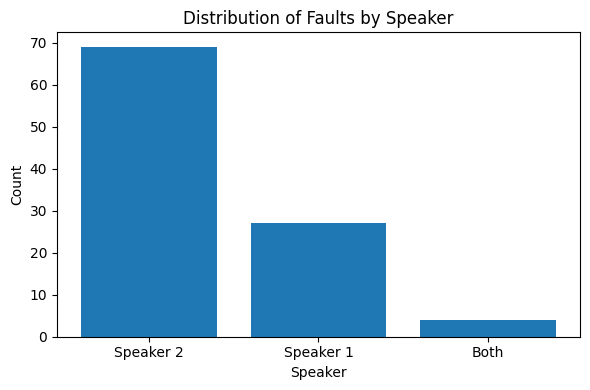

In [ ]:
normalized_faults = []
for r in results_loaded:
    fault = r['fault'].strip().lower()
    if "1" in fault:
        normalized_faults.append("Speaker 1")
    elif "2" in fault:
        normalized_faults.append("Speaker 2")
    else:
        normalized_faults.append("Both")

# Count occurrences
fault_counts = Counter(normalized_faults)

# Plot
plt.figure(figsize=(6, 4))
plt.bar(fault_counts.keys(), fault_counts.values())
plt.title("Distribution of Faults by Speaker")
plt.xlabel("Speaker")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


### **Feedback on How Communication Can be Improved**

In [207]:
def provide_feedback_workplace(dialogue):
  return generate(model = '4o-mini',
        system = 'Analyze the dialogue as specified below.',
        query = dialogue + '\n\nIn the dialogue above, Speaker 1 uses an indirect speech act and Speaker 2 responds to it literally. As a communication expert, what feedback would you provide to the speaker(s)? Output a dictionary formatted as follows: { "feedback":"Your feedback, if any."}',
        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)


In [208]:
with open('indirect_generated_data/indirect_workplace.json') as f:
    indirect_statements_generated_workplace = json.load(f)
    
indirect_statements_generated_workplace[0:2]


[{'Speaker 1': 'It seems like everyone is really busy today.',
  'Speaker 2': 'Yeah, I love how productive we all are.'},
 {'Speaker 1': 'This coffee tastes a bit off this morning.',
  'Speaker 2': "Oh, I'm glad you got your coffee! You should have some every day."}]

In [209]:
def process_dialogue(i):
    dialogue = '\n'.join([f"{speaker}: {statement}" for speaker, statement in indirect_statements_generated_workplace[i].items()])
    response = provide_feedback_workplace(dialogue)['response']
    return ast.literal_eval(response)

with ThreadPoolExecutor(max_workers=10) as executor:
    results = list(executor.map(process_dialogue, range(10)))


In [210]:
with open('indirect_analysis_data/workplace/provide_feedback.json', 'w') as f:
    json.dump(results, f, indent=2)


In [211]:
with open('indirect_analysis_data/workplace/provide_feedback.json') as f:
    results_loaded = json.load(f)

results_loaded[0:10]


[{'feedback': "Speaker 1 could clarify their intention by expressing how being busy might affect collaboration or other aspects of their work environment. Speaker 2's literal response is positive but misses the nuance of the concern implied by Speaker 1's observation. They could acknowledge the productivity while also considering the impact of being overly busy."},
 {'feedback': "Speaker 1 could consider being more explicit about their discomfort with the coffee to ensure their message is clearly understood. Speaker 2 might benefit from acknowledging the issue raised by Speaker 1 instead of responding with a generic comment about coffee. This would enhance the communication and show better empathy towards Speaker 1's experience."},
 {'feedback': "Speaker 1's indirect question about the meeting attendance could have been met with a more empathetic or engaging response from Speaker 2, acknowledging the concern while providing information. A possible improvement for Speaker 2 could be to 

### **Feedback - Autistic**

In [213]:
def provide_feedback_autistic_workplace(dialogue):
  return generate(model = '4o-mini',
        system = 'Analyze the dialogue as specified below.',
        query = dialogue + '\n\nIn the dialogue above, Speaker 1 uses an indirect speech act and Speaker 2 responds to it literally. As a communication expert, what feedback would you provide to the speaker 2, provided they are autistic? Output a dictionary formatted as follows: { "feedback":"Your feedback, if any."}',
        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)


In [214]:
with open('indirect_generated_data/indirect_workplace.json') as f:
    indirect_statements_generated_workplace = json.load(f)
    
indirect_statements_generated_workplace[0:2]


[{'Speaker 1': 'It seems like everyone is really busy today.',
  'Speaker 2': 'Yeah, I love how productive we all are.'},
 {'Speaker 1': 'This coffee tastes a bit off this morning.',
  'Speaker 2': "Oh, I'm glad you got your coffee! You should have some every day."}]

In [215]:
def process_dialogue(i):
    dialogue = '\n'.join([f"{speaker}: {statement}" for speaker, statement in indirect_statements_generated_workplace[i].items()])
    response = provide_feedback_autistic_workplace(dialogue)['response']
    return ast.literal_eval(response)

with ThreadPoolExecutor(max_workers=10) as executor:
    results = list(executor.map(process_dialogue, range(10)))


In [216]:
with open('indirect_analysis_data/workplace/autistic_two_feedback.json', 'w') as f:
    json.dump(results, f, indent=2)


In [217]:
with open('indirect_analysis_data/workplace/autistic_two_feedback.json') as f:
    results_loaded = json.load(f)

results_loaded[0:10]


[{'feedback': "It's great that you responded literally, but you might want to consider the context of conversations and how people may not always mean what they say directly. In this case, Speaker 1 might be expressing concern about busyness rather than just stating an observation. You could try to engage more by acknowledging their concern or sharing your own feelings about productivity."},
 {'feedback': "Consider acknowledging Speaker 1's concern about the coffee taste directly. You might respond with something like, 'I'm sorry to hear that! What do you think is off about it?' This would show empathy and help clarify the situation."},
 {'feedback': "Consider acknowledging Speaker 1's concern about the meeting attendance directly. You could say something like, 'I hope some people will come!' to show you're engaging with their thought."},
 {'feedback': "It's great that you responded positively to the idea of challenges! However, it might help to share some empathy or acknowledge the di

### **Feedback - Non-autistic**

In [219]:
def provide_feedback_non_autistic_workplace(dialogue):
  return generate(model = '4o-mini',
        system = 'Analyze the dialogue as specified below.',
        query = dialogue + '\n\nIn the dialogue above, Speaker 1 uses an indirect speech act and Speaker 2 responds to it literally. As a communication expert, what feedback would you provide to the speaker 2, provided they are not autistic? Output a dictionary formatted as follows: { "feedback":"Your feedback, if any."}',
        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)


In [220]:
with open('indirect_generated_data/indirect_workplace.json') as f:
    indirect_statements_generated_workplace = json.load(f)
    
indirect_statements_generated_workplace[0:2]


[{'Speaker 1': 'It seems like everyone is really busy today.',
  'Speaker 2': 'Yeah, I love how productive we all are.'},
 {'Speaker 1': 'This coffee tastes a bit off this morning.',
  'Speaker 2': "Oh, I'm glad you got your coffee! You should have some every day."}]

In [221]:
def process_dialogue(i):
    dialogue = '\n'.join([f"{speaker}: {statement}" for speaker, statement in indirect_statements_generated_workplace[i].items()])
    response = provide_feedback_non_autistic_workplace(dialogue)['response']
    return ast.literal_eval(response)

with ThreadPoolExecutor(max_workers=10) as executor:
    results = list(executor.map(process_dialogue, range(10)))


In [222]:
with open('indirect_analysis_data/workplace/non_autistic_two_feedback.json', 'w') as f:
    json.dump(results, f, indent=2)


In [223]:
with open('indirect_analysis_data/workplace/non_autistic_two_feedback.json') as f:
    results_loaded = json.load(f)

results_loaded[0:10]


[{'feedback': "Consider acknowledging the underlying sentiment of Speaker 1's comment about busyness, possibly expressing understanding or empathy rather than just agreeing on productivity."},
 {'feedback': "Consider acknowledging Speaker 1's concern about the coffee instead of responding literally. A more empathetic response could help validate their feelings and open up a better dialogue about the coffee's taste."},
 {'feedback': "Consider acknowledging Speaker 1's concern about attendance and engaging with their indirect question more directly. You could respond with something like, 'I hope so! It would be great to have everyone there.' This would show that you are aware of their inquiry and are interested in the meeting's dynamics."},
 {'feedback': "Consider acknowledging Speaker 1's feelings more directly. Responding with empathy may encourage a more supportive dialogue."},
 {'feedback': "Consider recognizing the indirect nature of Speaker 1's comment. They may be expressing a des

### **Identify Autistic Speaker**


In [225]:
def identify_autistic_speaker(dialogue):
  return generate(model = '4o-mini',
        system = 'Analyze the dialogue as specified below.',
        query = dialogue + '\n\nBased on the dialogue above, can you identify which speaker is autistic: Speaker 1, Speaker 2 or neither? Explain your decision. Output a dictionary formatted as follows: { "autistic":"Speaker # or neither", "explanation":"A detailed explanation for your decision."}',
        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)


In [226]:
with open('indirect_generated_data/indirect_workplace.json') as f:
    indirect_statements_generated_workplace = json.load(f)
    
indirect_statements_generated_workplace[0:2]


[{'Speaker 1': 'It seems like everyone is really busy today.',
  'Speaker 2': 'Yeah, I love how productive we all are.'},
 {'Speaker 1': 'This coffee tastes a bit off this morning.',
  'Speaker 2': "Oh, I'm glad you got your coffee! You should have some every day."}]

In [227]:
def process_dialogue(i):
    dialogue = '\n'.join([f"{speaker}: {statement}" for speaker, statement in indirect_statements_generated_workplace[i].items()])
    response = identify_autistic_speaker(dialogue)['response']
    return ast.literal_eval(response)

with ThreadPoolExecutor(max_workers=10) as executor:
    results = list(executor.map(process_dialogue, range(100)))


In [228]:
with open('indirect_analysis_data/workplace/autistic_speaker.json', 'w') as f:
    json.dump(results, f, indent=2)


In [229]:
with open('indirect_analysis_data/workplace/autistic_speaker.json') as f:
    results_loaded = json.load(f)

results_loaded[0:2]


[{'autistic': 'neither',
  'explanation': "There is no definitive indication in the dialogue that either speaker is autistic. Speaker 1 makes an observation about the group's busyness, which could be seen as a social awareness. Speaker 2 responds positively, expressing appreciation for productivity, which suggests they are engaging in a typical social exchange. Both speakers demonstrate a relatable understanding of the context without any specific traits or communication styles that would suggest autism."},
 {'autistic': 'neither',
  'explanation': 'The dialogue provided does not offer clear indications of autism traits in either speaker. Speaker 1 expresses a specific observation about the taste of the coffee, which is a typical sensory experience. Speaker 2 responds positively by encouraging regular coffee consumption, which shows an understanding of social norms but does not demonstrate autistic characteristics such as difficulties in social communication or rigidity in behavior. Th

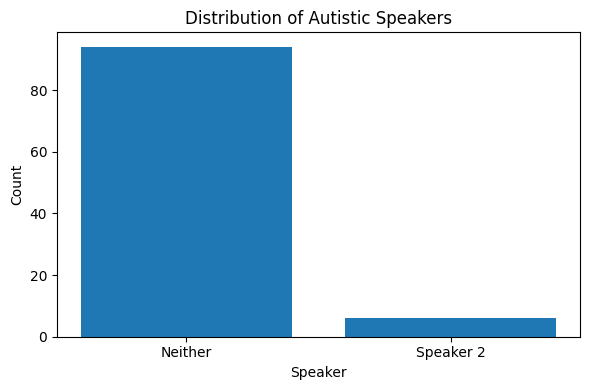

In [230]:
normalized_faults = []
for r in results_loaded:
    fault = r['autistic'].strip().lower()
    if "1" in fault:
        normalized_faults.append("Speaker 1")
    elif "2" in fault:
        normalized_faults.append("Speaker 2")
    else:
        normalized_faults.append("Neither")

# Count occurrences
fault_counts = Counter(normalized_faults)

# Plot
plt.figure(figsize=(6, 4))
plt.bar(fault_counts.keys(), fault_counts.values())
plt.title("Distribution of Autistic Speakers")
plt.xlabel("Speaker")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
